Completing scanpy tutorial of scRNAseq analysis from https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html

Downloaded dataset: pbmc3k_filtered_gene_bc_matrices.tar

unpacked with 
``` bash
tar -xvf pbmc3k_filtered_gene_bc_matrices.tar
```

In [1]:
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.12


In [3]:
results_file = "/scratch/user/s4436039/scdata/3kPBMC/pbmc3k.h5ad"  # the file that will store the analysis results

In [4]:
#read in the count matrix into an AnnData object
adata = sc.read_10x_mtx(
    "/scratch/user/s4436039/scdata/3kPBMC/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


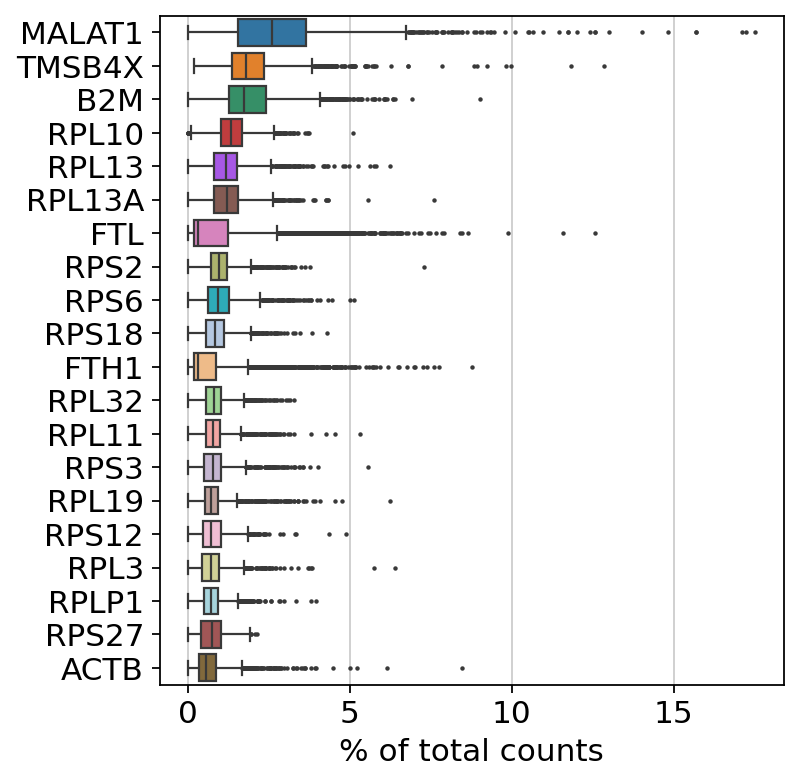

In [8]:
#show those genes that yield the highest fractiona of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
#basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [10]:
#next assemble information about mitochondiral genes, which are important for quality control --> high proportions are indicative of poor-quality cells 
#With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

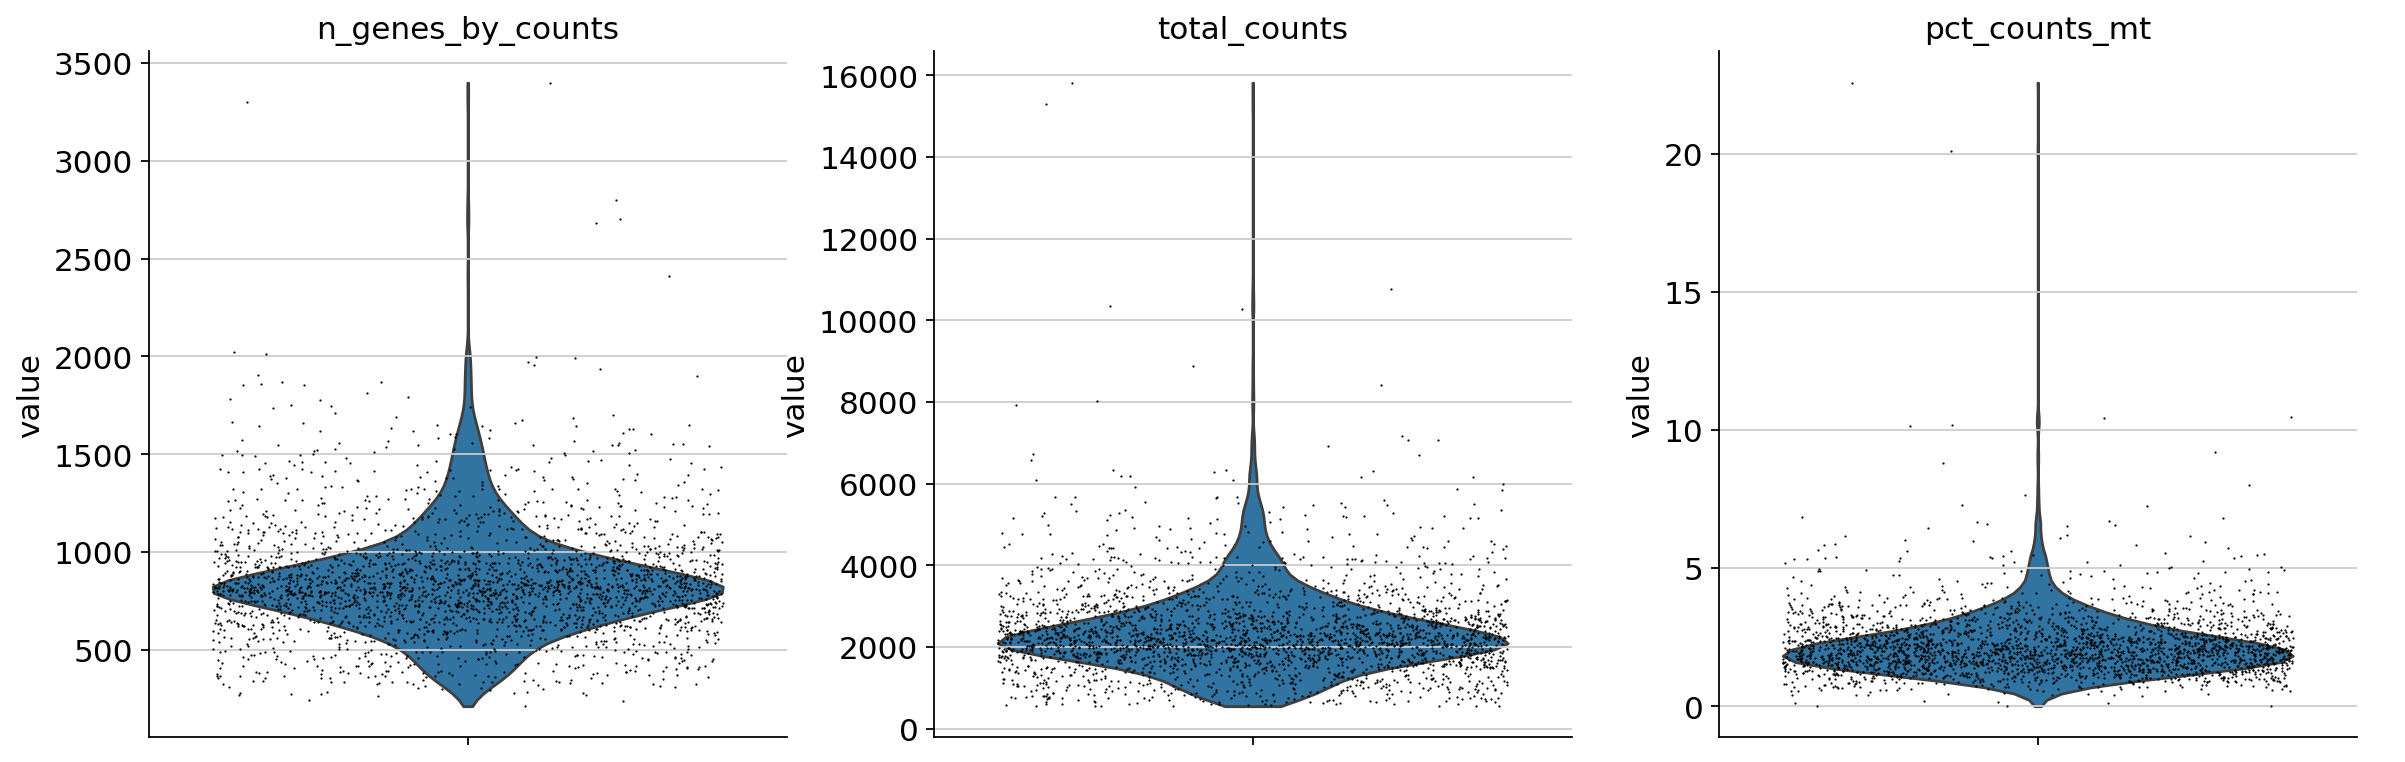

In [11]:
#A violin plot of some of the computed quality measures:
##- the number of genes expressed in the count matrix
##- the total counts per cell
##- the percentage of counts in mitochondrial genes

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

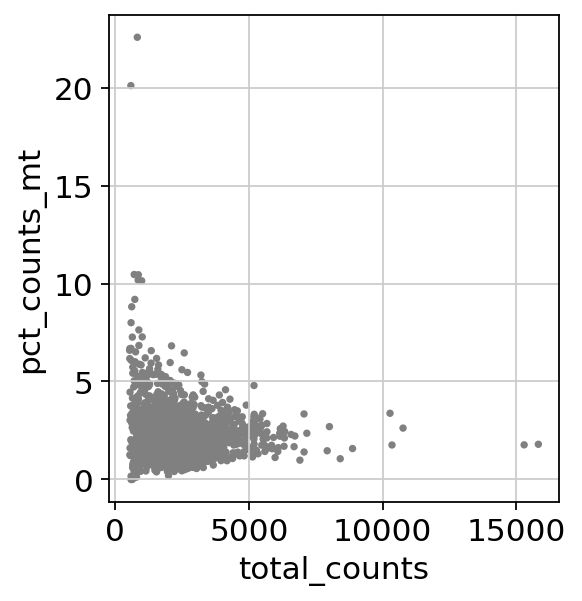

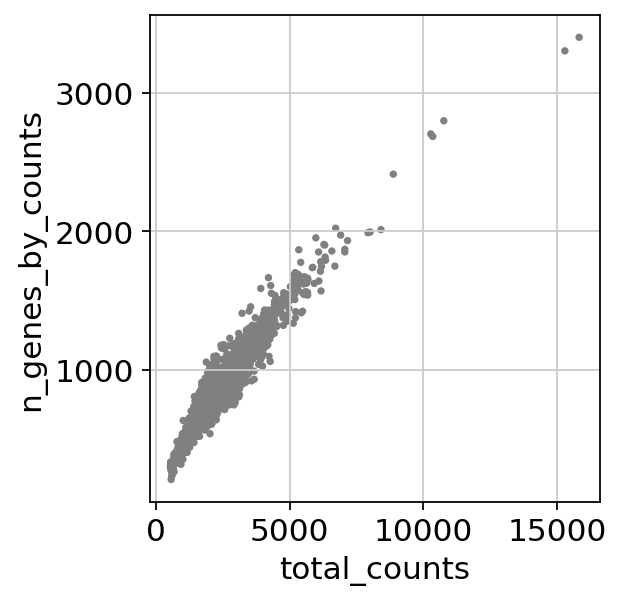

In [12]:
#Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [13]:
#Actually do the filtering by slicing the AnnData object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [14]:
#Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [15]:
#Logarithmize the data
sc.pp.log1p(adata)

In [16]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


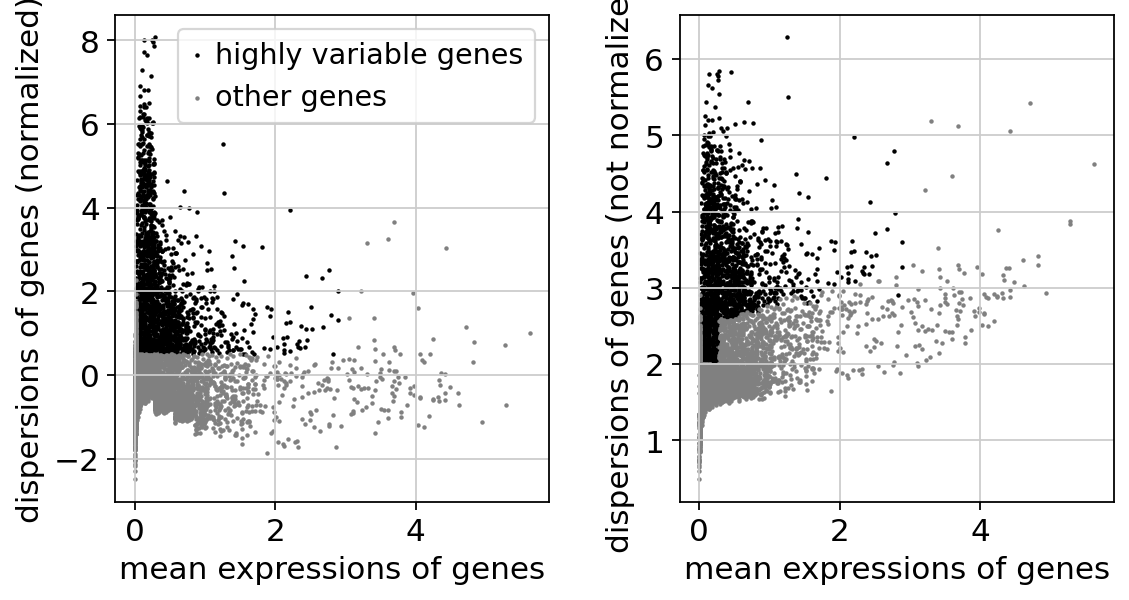

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression 
#for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

#Note: You can get back an AnnData of the object in .raw by calling .raw.to_adata().

adata.raw = adata

In [19]:
#filtering
adata = adata[:, adata.var.highly_variable]

In [20]:
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:07)


In [21]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

Principle component analysis:

In [22]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


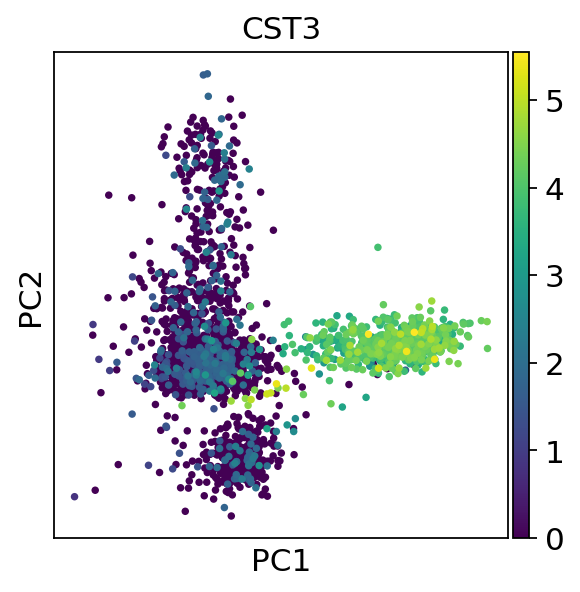

In [23]:
#We can make a scatter plot in the PCA coordinates, but we will not use that later on.
sc.pl.pca(adata, color="CST3")

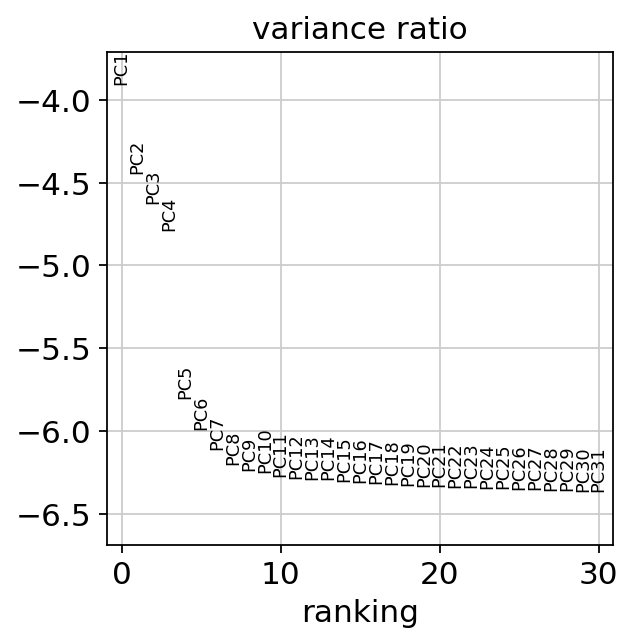

In [24]:
#Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the 
#neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
#save the result
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Computing the neighborhood graph

In [26]:
#Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing 
#Seurat’s results, let’s take the following values.

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [29]:
#embed the neighborhood graoh in two dimensions using UMAP
sc.tl.umap(adata, min_dist=0.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


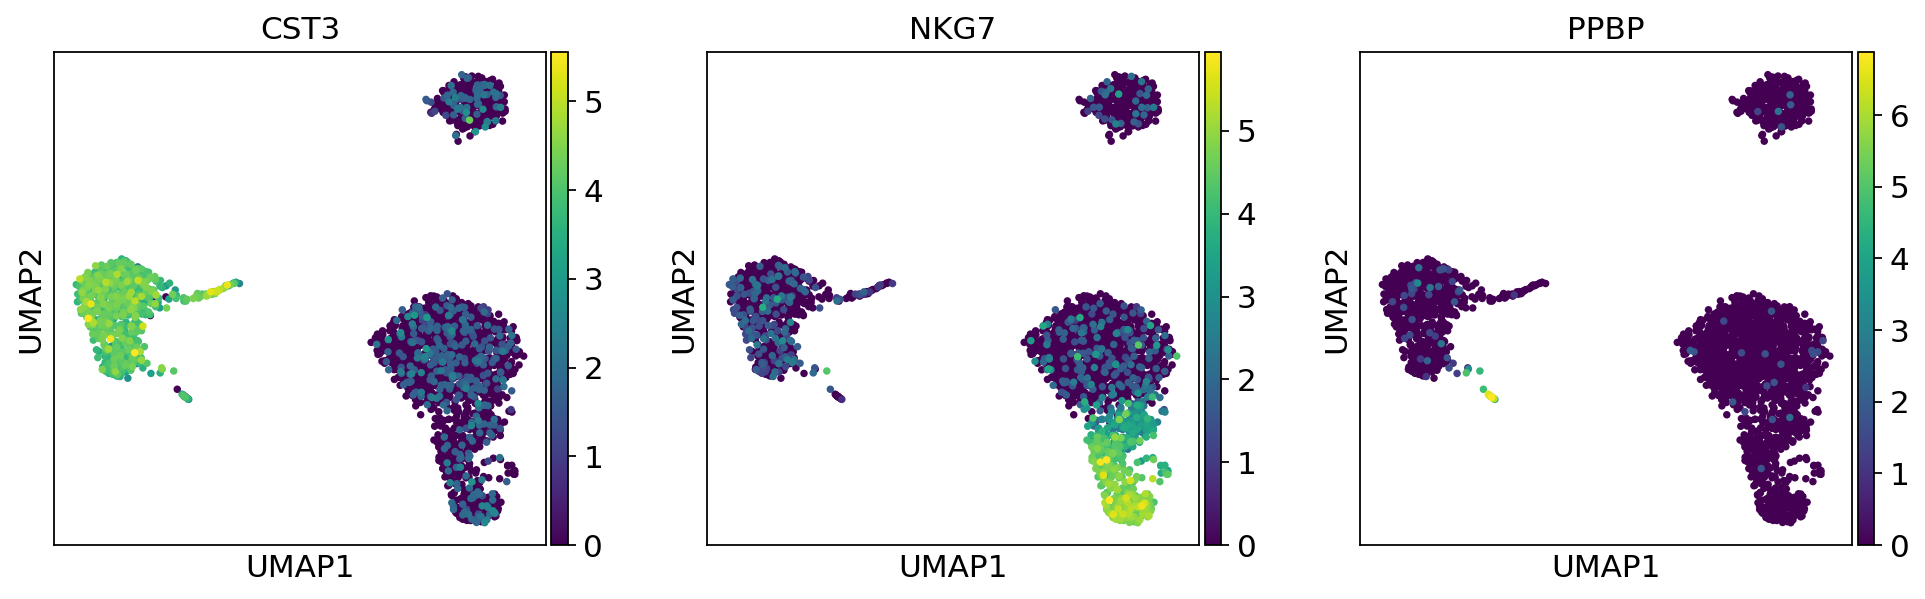

In [32]:
#visualise UMAP
sc.pl.umap(
    adata,
    color=[
        "CST3",
        "NKG7",
        "PPBP",
    ],
    ncols=3
)

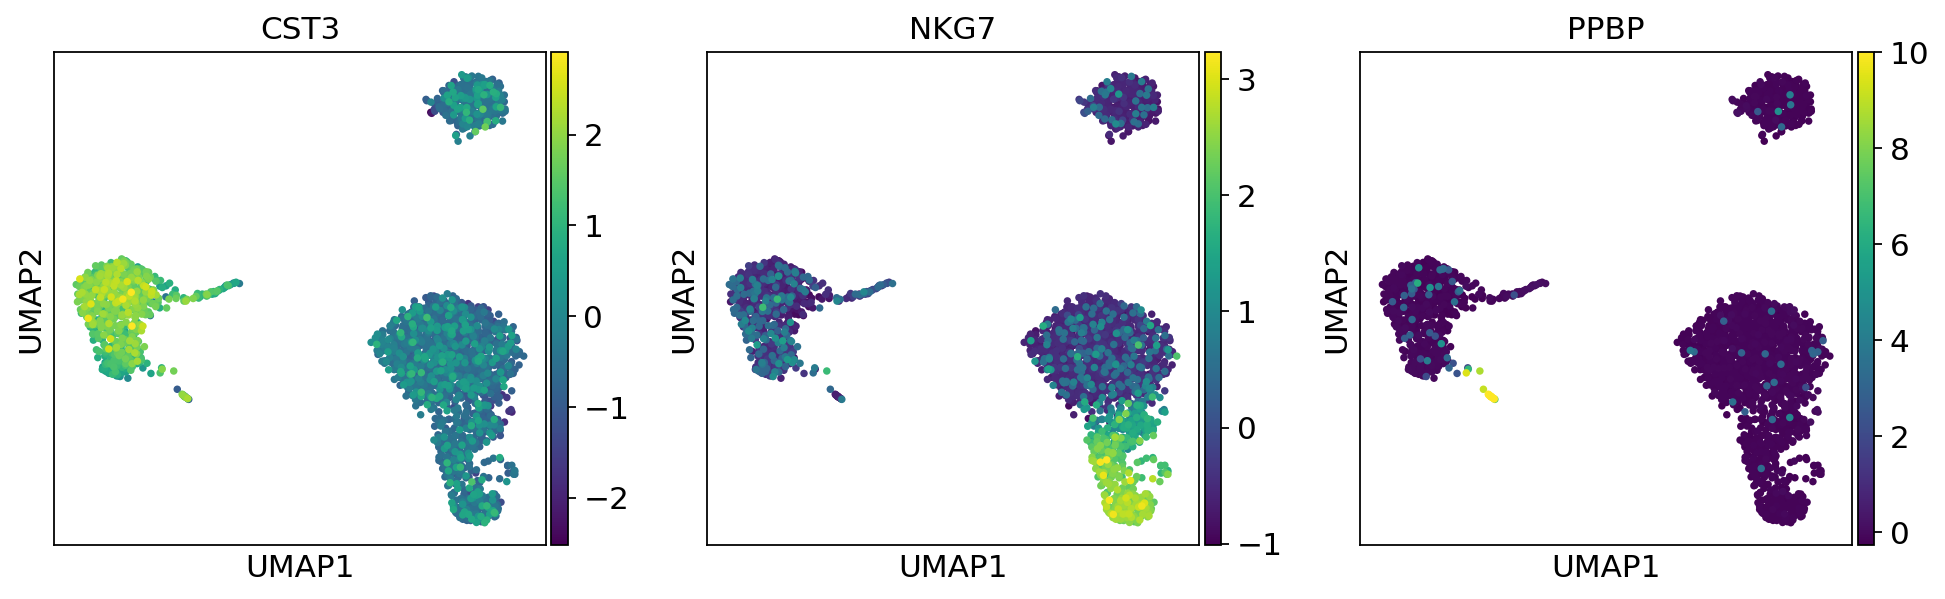

In [33]:
#As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and 
#corrected gene expression by explicitly stating that you don’t want to use .raw

sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

Clustering the neighborhood graph

In [35]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering


    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


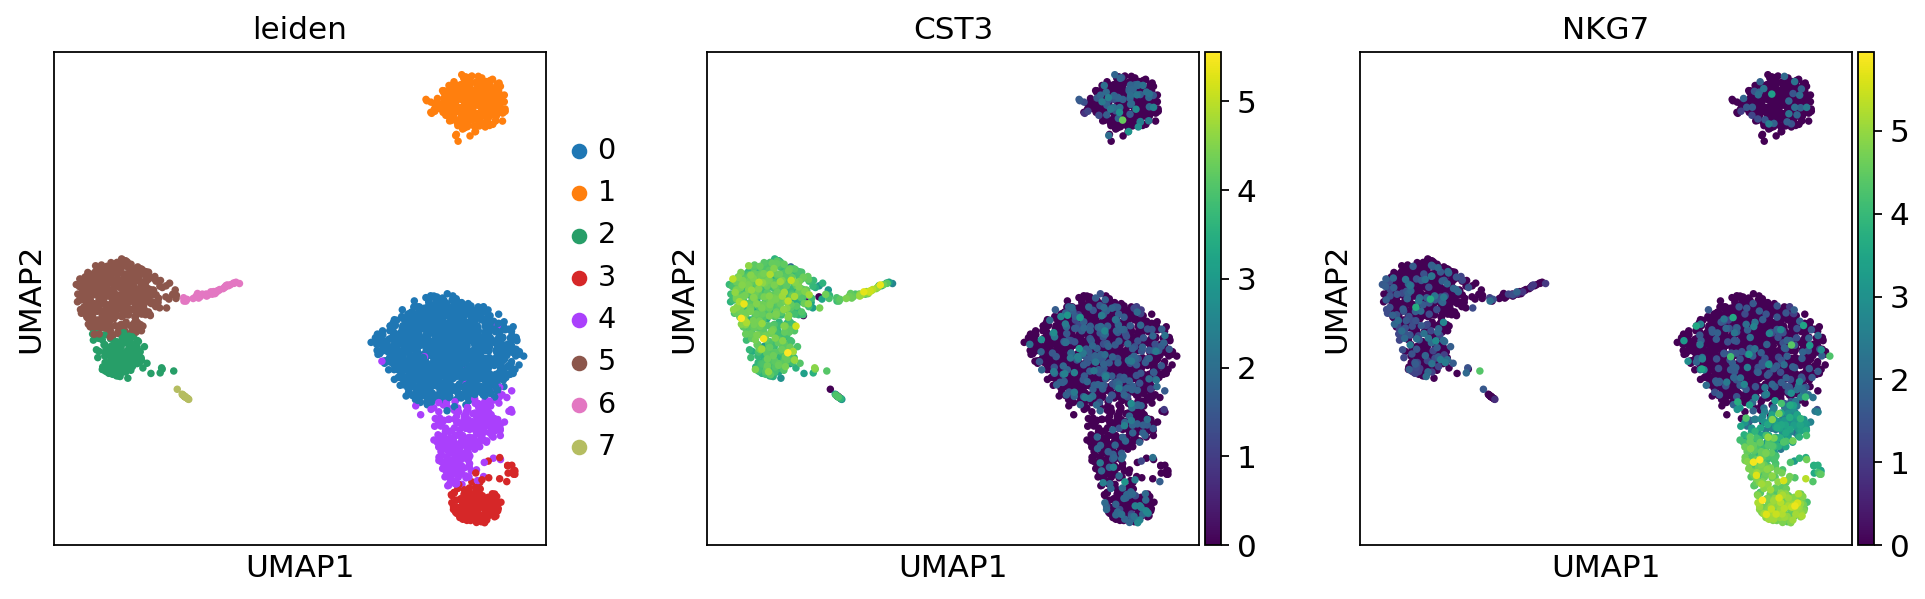

In [36]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [37]:
adata.write(results_file)

In [39]:
import os

In [40]:
os.getcwd()

'/scratch/user/s4436039/Nikita-project'